In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os

/home/dzheglov/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
tf.__version__

'1.5.0'

In [3]:
tf.test.gpu_device_name()

''

In [4]:
# for the sake of reproducibility 

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# Outline

* [RNN recap](#RNN-recap)
    - [Task1](#Task1)
    - [Dynamic RNN](#Dynamic-RNN)
* [Generate names with RNN](#Name-generation)
    - [Task2](#Task2)
* [SRU implementation](#SRU-implementation)
    - [Task3](#Task3)
* [Bonus part](#Bonus-part)
* [How to evaluate the work](#How-to-evaluate-the-work)

# RNN recap

<img src="./pics/rnn.png" width="90%">

Simplest RNN consisting of 1 layer receives $x_{(t)}$ and could be written as:

$$y_{(t)} = \phi (x_{(t)}^T \cdot w_x + y_{(t-1)}^T \cdot w_y + b)$$

where 
* $x(t)$ -- input vector at time step _t_ 
* $y(t)$ -- output vector at time step _t_
* $w_x$ -- weights vector for input 
* $w_y$ -- weights vector for output
* $y(t-1)$ -- output vector at previous time step; for 0th step it's zero vector
* $b$ -- bias
* $\phi$ -- some activation function, i.e. ReLU


Also we should mention **hidden_state** ( $h(t)$ ) -- it's a recurrent cell memory.

In general case $h_{(t)} = f(h_{(t-1)}, x_{(t)})$, but also $y{(t)} = f(h{(t-1)}, x{(t)})$. So in this case $h(t) == y(t)$, but in practice more complex architectures are used, where **hidden_state** is not equal to the RNN output.

------

## Lets write simple RNN
To write RNN we need to make few improvements to the formula.

Lets say that we have not only one vector $x_{(t)}$ as input, but a few vectors in mini-batch $X_{(t)}$ of size $m$ . So all consequent computaions will be in a matrix form.

$$ Y_{(t)} = \phi(X_{(t)} \cdot W_x + Y_{(t-1)} \cdot W_y + b) = \phi([X_{(t)} Y_{(t-1)}] \cdot W + b) $$
where
$$ W = [W_x W_y]^T $$

*It's a matrix concatination in square brackets

Dimentions:
* $Y_{(t)}$ -- matrix [$m$ x n_neurons]
* $X_{(t)}$ -- matrix [$m$ x n_features]
* $b$ -- vector of size `n_neurons`
* $W_x$ -- input weights of size [n_features x n_neurons]
* $W_y$ -- output weights of size [n_neurons x n_neurons]

In [5]:
reset_graph() # just clear default graph and set seed for reproducibility

n_features = 3
n_neurons = 5

# two time steps
# the first dimension in shape parameter is None
# because of possibility to feed any sized batch

X0 = tf.placeholder(tf.float32, shape=[None, n_features])
X1 = tf.placeholder(tf.float32, shape=[None, n_features])

Wx = tf.Variable(tf.random_normal(shape=[n_features, n_neurons], dtype=tf.float32))
Wy = tf.Variable(tf.random_normal(shape=[n_neurons, n_neurons], dtype=tf.float32))
b = tf.Variable(tf.zeros([1, n_neurons], dtype=tf.float32))

# tanh as phi
Y0 = tf.tanh(tf.matmul(X0, Wx) + b)
Y1 = tf.tanh(tf.matmul(Y0, Wy) + tf.matmul(X1, Wx) + b)

init = tf.global_variables_initializer()

In [6]:
# mini-batches of size 4
X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]])  # time step 0 of mini-batch
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]])  # time step 2 mini-batch


with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [7]:
Y0_val

array([[-0.0664006 ,  0.9625767 ,  0.68105793,  0.7091854 , -0.898216  ],
       [ 0.9977755 , -0.719789  , -0.9965761 ,  0.9673924 , -0.9998972 ],
       [ 0.99999774, -0.99898803, -0.9999989 ,  0.9967762 , -0.9999999 ],
       [ 1.        , -1.        , -1.        , -0.99818915,  0.9995087 ]],
      dtype=float32)

In [8]:
Y1_val

array([[ 1.        , -1.        , -1.        ,  0.4020025 , -0.9999998 ],
       [-0.12210421,  0.6280527 ,  0.9671843 , -0.9937122 , -0.25839362],
       [ 0.9999983 , -0.9999994 , -0.9999975 , -0.8594331 , -0.9999881 ],
       [ 0.99928284, -0.99999815, -0.9999058 ,  0.9857963 , -0.92205757]],
      dtype=float32)

## Task1

Make the same computation using only one matrix multiplication per one step.

In [9]:
reset_graph() # just clear default graph and set seed for reproducibility

X0 = tf.placeholder(tf.float32, [None, n_features])
X1 = tf.placeholder(tf.float32, [None, n_features])

#< your code here >
W = tf.Variable(tf.random_normal(shape=[n_features + n_neurons, n_neurons], dtype=tf.float32))
b = tf.Variable(tf.zeros([1, n_neurons], dtype=tf.float32))

Y0 = tf.tanh(tf.matmul(tf.concat([X0, tf.fill(tf.stack([tf.shape(X0)[0], n_neurons]), 0.0)], axis = -1), W) + b)
Y1 = tf.tanh(tf.matmul(tf.concat([X1, Y0], axis = -1), W) + b)
init = tf.global_variables_initializer()
#second way
#Wx = tf.Variable(tf.random_normal(shape=[n_features, n_neurons], dtype=tf.float32))
#Wy = tf.Variable(tf.random_normal(shape=[n_neurons, n_neurons], dtype=tf.float32))
#Y0 = tf.tanh(tf.matmul(X0, Wx) + b)
#Y1 = tf.tanh(tf.matmul(tf.concat([X1, Y0], 1), tf.concat([Wx, Wy], 0)) + b)


with tf.Session() as sess:
    init.run()
    Y0_val_1, Y1_val_1 = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

# Dynamic RNN

In TensorFlow there is a function `tf.contrib.rnn.static_rnn` which create for each time step (unrolling) specific cell of desired type. Our implementation follows `tf.nn.rnn_cell.BasicRNNCell`. This implementation has such a drawback - we could need a lot of memory for long sequences. And because we want to work with such sequences we need to allocate a lot of memory at once. But in TF there is another option -- `dynamic_rnn`, where memory is allocated dynamically for each provided sequence, acording to its length.

Lets rewrite the code with `dynamic_rnn`.

As always in tensorflow the first step is writing a recipe.

In [10]:
n_steps = 2
n_features = 3
n_neurons = 5

reset_graph() # just clear default graph and set seed for reproducibility

# adding new parts to the default graph
X = tf.placeholder(tf.float32, [None, n_steps, n_features])

# we have created the same cell in the Task1;
basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)

In [11]:
seq_length = tf.placeholder(tf.int32, [None]) # create placeholder to feed in real values;

# create dynamic_rnn and connect all existing graph components to it (i.e basic_cell, X, seq_length);
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32,
                                    sequence_length=seq_length)

Now create matrices with real values in numpy.

Notice that now `X_batch` have shape = `[None, n_steps, n_features]` that is not the same as in `Task1`.

That's because of putting all time steps of batch instances in a single matrix `X_batch` (in the `Task1` we used two separated matrices `X0` and `X1` to feed values in each time stamp).

In [12]:
X_batch = np.array([
        # step 0     step 1
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2 (padded with zero vectors)
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

# sequence lengths
seq_length_batch = np.array([2, 1, 2, 2]) # note the length of second instance is 1

Feed these real values into created network to get outputs and states values.

In [13]:
# create new session context manager;
# session will be closed as soon as this cell finish running
with tf.Session() as sess:
    tf.global_variables_initializer().run() # initialize all variables
    
    # run session and feed input values into the network, get outputs and states values
    outputs_val, states_val = sess.run(
        [outputs, states], feed_dict={X: X_batch, seq_length: seq_length_batch})

The shape of `outputs_val` is `[batch_size, time_steps, n_neurons]` as it returns all outputs for each time step for each instance.

The shape of `states_val` is `[batch_size, n_neurons]` as it returns only last state for each instance of batch.

__For the BasicRNNCell outputs and states are the same.__

In [14]:
print(outputs_val.shape)
print(states_val.shape)

(4, 2, 5)
(4, 5)


In [15]:
# for the second sample there are zeros in output 
print(outputs_val)

[[[ 0.65519077 -0.38949275 -0.6105231   0.5927638  -0.48083815]
  [ 0.9999941   0.99594396  0.4582593   0.9991697   0.8991136 ]]

 [[ 0.9978262   0.44117272 -0.5916074   0.9749958  -0.35678416]
  [ 0.          0.          0.          0.          0.        ]]

 [[ 0.9999887   0.87606186 -0.5720173   0.99874693 -0.21872665]
  [ 0.9995612   0.9808731   0.8890911   0.9768431   0.5203418 ]]

 [[ 0.9990465   0.92710733  0.23267001  0.9804318   0.99994713]
  [ 0.9791339   0.719474    0.93568635  0.63649696 -0.17854698]]]


In [16]:
# but in state there are not
print(states_val)

[[ 0.9999941   0.99594396  0.4582593   0.9991697   0.8991136 ]
 [ 0.9978262   0.44117272 -0.5916074   0.9749958  -0.35678416]
 [ 0.9995612   0.9808731   0.8890911   0.9768431   0.5203418 ]
 [ 0.9791339   0.719474    0.93568635  0.63649696 -0.17854698]]


If we feed `sequence_length` parameter into the `dynamic_rnn` we make `dynamic_rnn` to stop calculating states after actual sequence is ended. If we don't provide `sequence_length` parameter the calculating of states will continue and useful information about sequence could be lost if the padding is long enough. 

# Name generation

Lets try to do something useful with our RNNs.

_Teaser:_

* It is hard to choose a name for a variable. But its much harder to choose a name for a person.
  So lets make neural net to do it instead!
* Dataset consists of 8 thousand people names from different cultures all around the world.
* Our toy task is training a model for name generation.

In [17]:
start_token = " "

with open("names") as f:
    names = f.readlines()
    names = [start_token + name.lower() for name in names]

In [18]:
print('n samples = ', len(names))
for x in names[::1000]:
    print(x.strip().capitalize())

n samples =  7944
Abagael
Claresta
Glory
Liliane
Prissie
Geeta
Giovanne
Piggy


### Text processing

Lets take all the latters disregarding a case + symbol ')' for the end of a name

In [19]:
token_set = set()
for name in names:
    for letter in name:
        token_set.add(letter)


token_set.add(')')
tokens = list(token_set)
tokens.sort()

print('n_tokens = ', len(tokens))

n_tokens =  31


In [20]:
token_to_id = {t: i for i, t in enumerate(tokens)}

id_to_token = {i: t for i, t in enumerate(tokens)}

### Name length distribution

16


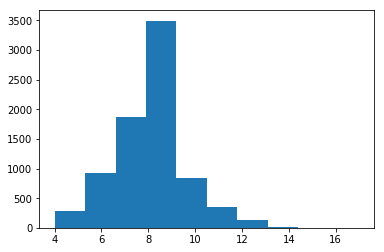

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(list(map(len, names)))

# max length of a name in this dataset
MAX_LEN = min([60, max(list(map(len, names)))])-1

print(MAX_LEN)

### Convert symbols to their ids

In [22]:
names_ix = list(map(lambda name: list(map(token_to_id.get, name + ')')), names))


for i in range(len(names_ix)):
    names_ix[i] = names_ix[i][:MAX_LEN+1] #crop too long
    
    if len(names_ix[i]) < MAX_LEN+1:
        names_ix[i] += [token_to_id[" "]]*(MAX_LEN+1 - len(names_ix[i])) #pad too short
        
assert len(set(map(len, names_ix))) == 1

names_ix = np.array(names_ix)

In [23]:
names_ix[:10]

array([[ 1,  5,  6,  5, 11,  5,  9, 16,  0,  3,  1,  1,  1,  1,  1,  1,
         1],
       [ 1,  5,  6,  5, 11,  5, 13, 16,  0,  3,  1,  1,  1,  1,  1,  1,
         1],
       [ 1,  5,  6,  6,  9,  0,  3,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1],
       [ 1,  5,  6,  6,  9, 29,  0,  3,  1,  1,  1,  1,  1,  1,  1,  1,
         1],
       [ 1,  5,  6,  6, 13,  0,  3,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1],
       [ 1,  5,  6,  6, 13,  9,  0,  3,  1,  1,  1,  1,  1,  1,  1,  1,
         1],
       [ 1,  5,  6,  6, 29,  0,  3,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1],
       [ 1,  5,  6, 13, 11,  5,  9, 16,  0,  3,  1,  1,  1,  1,  1,  1,
         1],
       [ 1,  5,  6, 13, 11,  5, 13, 16,  0,  3,  1,  1,  1,  1,  1,  1,
         1],
       [ 1,  5,  6, 13, 11,  5, 16,  9,  0,  3,  1,  1,  1,  1,  1,  1,
         1]])

### Batch generator

In [24]:
def sample_batch(data, batch_size):
    
    rows = data[np.random.randint(0, len(data), size=batch_size)]
    x = rows[:, :-1]
    y = rows[:, 1:]
    
    count = lambda r: np.sum([id_to_token[t] != ' ' for t in r])
    lengths = list(map(count, x))
    
    return x, y, lengths

In [25]:
x, y, length = sample_batch(names_ix, 10)
y.shape

(10, 16)

In [26]:
x

array([[ 1, 23,  5, 23,  7, 12,  5,  0,  3,  1,  1,  1,  1,  1,  1,  1],
       [ 1, 24, 19, 17, 16, 13, 18,  0,  3,  1,  1,  1,  1,  1,  1,  1],
       [ 1,  7,  9,  7, 13, 16,  9, 29,  0,  3,  1,  1,  1,  1,  1,  1],
       [ 1,  7,  5, 16,  8, 27,  9, 16, 16,  0,  3,  1,  1,  1,  1,  1],
       [ 1,  6,  5, 22, 18,  5,  6,  5, 23,  0,  3,  1,  1,  1,  1,  1],
       [ 1,  5, 25,  6,  9,  0,  3,  1,  1,  1,  1,  1,  1,  1,  1,  1],
       [ 1, 18, 13, 18,  9, 24, 24,  5,  0,  3,  1,  1,  1,  1,  1,  1],
       [ 1, 16, 19, 22, 13,  9,  0,  3,  1,  1,  1,  1,  1,  1,  1,  1],
       [ 1,  9, 16, 16, 13, 19, 24, 24,  0,  3,  1,  1,  1,  1,  1,  1],
       [ 1, 13, 26, 19, 22,  0,  3,  1,  1,  1,  1,  1,  1,  1,  1,  1]])

In [27]:
y

array([[23,  5, 23,  7, 12,  5,  0,  3,  1,  1,  1,  1,  1,  1,  1,  1],
       [24, 19, 17, 16, 13, 18,  0,  3,  1,  1,  1,  1,  1,  1,  1,  1],
       [ 7,  9,  7, 13, 16,  9, 29,  0,  3,  1,  1,  1,  1,  1,  1,  1],
       [ 7,  5, 16,  8, 27,  9, 16, 16,  0,  3,  1,  1,  1,  1,  1,  1],
       [ 6,  5, 22, 18,  5,  6,  5, 23,  0,  3,  1,  1,  1,  1,  1,  1],
       [ 5, 25,  6,  9,  0,  3,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
       [18, 13, 18,  9, 24, 24,  5,  0,  3,  1,  1,  1,  1,  1,  1,  1],
       [16, 19, 22, 13,  9,  0,  3,  1,  1,  1,  1,  1,  1,  1,  1,  1],
       [ 9, 16, 16, 13, 19, 24, 24,  0,  3,  1,  1,  1,  1,  1,  1,  1],
       [13, 26, 19, 22,  0,  3,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1]])

In [28]:
length

[8, 8, 9, 10, 10, 6, 9, 7, 9, 6]

## Network architecture and text generation process


We will implement the class `MyLittleNetwork` which will be used to generate sequences.

<img src="https://vignette.wikia.nocookie.net/mlp/images/4/48/FANMADE_Rainbow_Dash_flying.png/revision/latest?cb=20121227194529" width="100" align="right">

Implemented class will have two useful properties:
* Several instances of the class could live in one default graph thanks to using `tf.variable_scope()`
* Each class instance could be created with its own recurrent cell type.

These properties are useful for us as we want to compare several cell types by creating several class instances.

**Outline of our work**

1. **[[Build]](#Building-network-graph)** Creating network graph in `MyLittleNetwork.__init__` method
2. **[[Train]](#Train-part)** Creating train procedure in `MyLittleNetwork.train` method
3. **[[Infer]](#Sequence-generation)** Creating generation procedure in `MyLittleNetwork.generate_sample` method



### Building network graph

Consider method `__init__`. It takes several parameters that will be further discussed.

```python
...................................................
def __init__(self, scope_name,
             embedding_size = 8,
             cell_class = tf.contrib.rnn.BasicRNNCell,
             cell_params_dict = {'num_units': 60, 'activation':tf.tanh},
             vocabulary_size = len(tokens)):
...................................................         
```
 
Here `scope_name` just used to separate graph variables belonging to this particular instance of class `MyLittleNetwork`. `Tf.variable_scope` just add `scope_name` to the full name of all graph variables. In other words `tf.variable_scope` used for namespaces in Tf.
We save `scope_name` parameter into `self.scope_name` to use this part of global default_graph along with a particular class instance.

In the snippet below we just creating placeholders for inputs `_X`, targets `_y`, sequence length and learning_rate within `scope_name`. We do that using context manager `with tf.variable_scope`.
```python
...................................................
self.scope_name = scope_name
with tf.variable_scope(self.scope_name):
    self._X = tf.placeholder(tf.int32, [None, None], name= 'X')
    self._y = tf.placeholder(tf.int32, [None, None], name = 'y')
    self._lengths = tf.placeholder(tf.int32, [None], name = 'lengths')
    self._learning_rate_ph = tf.placeholder(dtype=tf.float32, shape=[], name = 'learning_rate_ph')
...................................................
```

Look at the `_X` placeholder. It says you that it needs int32 input values. And there is no mistake.

As input we will feed a sequence of numbers (it's our mapping numbers in dictionary). Actual shape of the `_X` is not defined yet and could be any. But actually it is `(batch_size, max_sequence_length)`.

As you may remember from the part about [dynamic_rnn](#Dynamic-RNN) actually we feed into `dynamic_rnn` inputs with the shape `(batch_size, max_sequence_length, n_features)`. But how to get `n_features` dimension of inputs? Actually, we use `tf.embedding_lookup` function to map indices in `_X` to the vectors of embedding matrix. We put these obtained vectors to the `embed` variable.  And `_embedding_mtx` is just a usual `tf.Variable` with shape `(vocab_size, embedding_size)`. 

After obtaining embedding vectors for input `_X` we feed them into rnn cycle (i.e dynamic_rnn) which returns to us outputs and states (you may remember how it works from the [dynamic_rnn](#Dynamic-RNN) paragraph).   

Actually we could use further either `rnn_outputs` or `states` or both to obtain logits. You can try different settings.
But the most simple way is just using `rnn_outputs` as it contains information about each time step (and it is more then in `states`). So, use any option to obtain `_pred_logits` (i.e unnormalized scores for each token in the vocabulary).

In the last line of the snippet below you have to translate input `_y` to one_hot representation using tf function.
```python

...................................................
self._embedding_mtx = <create matrix of embeddings>
embed = < embed the input sequence >

self._cell = cell_class(**cell_params_dict)

rnn_outputs, states = tf.nn.dynamic_rnn(< choose params >)
self._pred_logits = < make logits >
labels_one_hot = < create one_hot for targets self._y >
...................................................
```

This is the last part of the architecture implementation.

`tf.softmax_cross_entropy_with_logits` measures the probability error in discrete classification tasks in which the classes are mutually exclusive. The function calculate `softmax` under unnormilized logits entirely for efficiency. It returns 1-D Tensor of length `batch_size` of the same type as logits with the softmax cross entropy loss. That means it calculates loss for each instance in the batch separately for all vocabulary using formula: $$- \Sigma y \cdot log(\hat{y})$$

Since we have one-hot distribution for $y$ the resulted loss (for each instance in batch) takes into account only the logit value of the corresponding right token. Minimizing this loss leads us to maximizing the similarity between distributions of $y$ and it's estimate $\hat{y}$.

But in fact, loss must be scalar value, not tensor. That's why we apply `tf.reduce_mean` function next.

Having loss function it is possible to take `AdamOptimizer` and minimize it (i.e calculate gradients giving a particular input and apply them to change network params). That's it and we will do that in the last line of this snippet. Besides we also define `_pred_probas` which is actually used only to generate sequence on the inference stage and doesn't need at train stage.

```python
....................................................
self._stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
                                                        labels=labels_one_hot,
                                                        logits=self._pred_logits)
self._loss = tf.reduce_mean(self._stepwise_cross_entropy, name='loss')

self._pred_probas = tf.nn.softmax(self._pred_logits, name='pred_probas')

self._train_op = tf.train.AdamOptimizer(self._learning_rate_ph)
                                        .minimize(self._loss, name='train_op')
...................................................
```

### Train part

To make computations run we need to create new tf.Session or use existing one which hasn't been already closed.
In this code snippet new session created but it used without context manager (i.e without `with tf.Session() ...`). It is useful to notice that fact as this session will be also used in the inference stage and we don't want to close it just after train finish.

As always we initialize variables in this session in this variable scope. 
```python
...................................................

def train(self, n_epochs=10, batches_per_epoch = 500, batch_size = 10, lr = 1e-2):

    losses = []
    self.sess = tf.Session() 
    with tf.variable_scope(self.scope_name):
        self.sess.run(tf.global_variables_initializer())
...................................................
```

In each epoch for each batch we run `_train_op` and get value of `_loss`.

All the loss values collected into `losses` list which is returned at the end of training.

See the next paragraph to understand `generate_sample` function.

```python
...................................................
for epoch in range(n_epochs):
    print(">>Generated: ", self.generate_sample(n_snippets=6))
    print("-------\n")
    avg_cost = 0
    for batch in range(batches_per_epoch):
        x_, y_, len_ = sample_batch(names_ix, batch_size)

        _, iloss = self.sess.run([self._train_op, self._loss],
                                   {self._X: x_,
                                    self._y: y_,
                                    self._lengths: len_,
                                    self._learning_rate_ph: lr})
        avg_cost += iloss
        losses.append(iloss)

    print("EPOCH: ", epoch)
    print("AVERAGE LOSS: ", avg_cost / batches_per_epoch)

print(">>Generated: ", self.generate_sample(n_snippets=6))
...................................................
```

### Sequence generation
**Inference stage**

<img src="http://tommymullaney.com/img/google-hangouts-feature.png" width="400">

**How it works?**

* Lets take seed phrase
* Feeding it to the network
* Predicting next token
    * Next token is being sampled from model predicted distribution
* Token is added to seed phrase
* Repeat (from step 2)


**`def generate_sample()`** in the *class `MyLittleNetwork`* actually do that. But it use `numpy` for sampling.
So it actually run session to get probability distribution for the last token, then sample with `numpy` from that distribution to get next token. Token then added to the seed phrase and everything starts again from feeding phrase into the network. The picture greatly illustrate the process. Generation ends when the end token {here we use that token `)`} has been sampled or when the max length riched.


It could be implemented more effectively using `tf.multinomial` and `tf.while_loop`.
You could try to implement this function for generation sequences using tf only. This part of task is challenging and very optional.


## Task2

Add your code where necessary to create network architecture


In [104]:
reset_graph()

class MyLittleNetwork:
    def __init__(self, scope_name,
                 embedding_size = 8,
                 cell_class = tf.contrib.rnn.BasicRNNCell,
                 cell_params_dict = {'num_units': 60, 'activation':tf.tanh},
                 vocabulary_size = len(tokens), multi = False, n_layers = 3):
        
        self.scope_name = scope_name
        
        with tf.variable_scope(self.scope_name):
            
            #################### PLACE FOR YOUR CODE  BELOW #########################
            #X = tf.placeholder(tf.int32, [None, None], name= 'X')
            #y = tf.placeholder(tf.int32, [None, None], name = 'y')
            #lengths = tf.placeholder(tf.int32, [None], name = 'lengths')
            #learning_rate_ph = tf.placeholder(dtype=tf.float32, shape=[])
            
            
            self._X = tf.placeholder(tf.int32, [None, None], name= 'X')
            self._y = tf.placeholder(tf.int32, [None, None], name = 'y')
            self._lengths = tf.placeholder(tf.int32, [None], name = 'lengths')
            self._learning_rate_ph = tf.placeholder(dtype=tf.float32, shape=[], name = 'learning_rate_ph')

            self._embedding_mtx = tf.get_variable(name='embeddings', shape=[vocabulary_size, embedding_size])#<create matrix of embeddings>
            embed = tf.nn.embedding_lookup(self._embedding_mtx, self._X)#< embed the input sequence >
            
            if multi == False:
                self._cell = cell_class(**cell_params_dict)
            else:
                layers = [cell_class(**cell_params_dict) for layer in range(n_layers)]
                self._cell = tf.contrib.rnn.MultiRNNCell(layers)
            rnn_outputs, states = tf.nn.dynamic_rnn(cell=self._cell, inputs=embed,
                                        sequence_length=self._lengths, dtype=tf.float32)
            self._pred_logits = tf.layers.dense(inputs=rnn_outputs, units=vocabulary_size, name='output_projection')#< make logits >
            labels_one_hot = tf.one_hot(self._y, depth=vocabulary_size, dtype=tf.float32)#< create one_hot for targets self._y >
            
            ##################### END OF YOUR TASK HERE ##############################

            self._stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
                                                                    labels=labels_one_hot,
                                                                    logits=self._pred_logits)

            self._loss = tf.reduce_mean(self._stepwise_cross_entropy, name='loss')

            self._pred_probas = tf.nn.softmax(self._pred_logits, name='pred_probas')

            self._train_op = tf.train.AdamOptimizer(self._learning_rate_ph).minimize(self._loss, name='train_op')
    
    def generate_sample(self, seed_phrase=None, N=MAX_LEN, n_snippets=1):
        """
        If you don't want to reimplement the function with tf
                        don't touch it!
        """
        if seed_phrase is None:
            seed_phrase = ' '
        elif seed_phrase[0].isalpha():
            seed_phrase = ' ' + seed_phrase
        seed_phrase = seed_phrase.lower()
        seed_phrase = np.array([token_to_id[tok] for tok in seed_phrase])
        L = len(seed_phrase)
        snippets = []
        
        with tf.variable_scope(self.scope_name):
            for _ in range(n_snippets):
                x = np.zeros(N)
                x[:len(seed_phrase)] = seed_phrase
                for n in range(N - L):
                    feed_dict = {self._X: x[:L + n].reshape([1, -1]), self._lengths: [len(x)]}
                    p = self.sess.run(self._pred_probas[:, -1], feed_dict=feed_dict).reshape(-1)
                    ix = np.random.choice(np.arange(len(tokens)), p=p)
                    x[L + n] = ix
                snippet = ''.join([id_to_token[idx] for idx in x])
                if ')' in snippet:
                    upto = snippet.index(')')
                    snippet = snippet[:upto]
                snippets.append(snippet.strip().capitalize())
        return snippets
    
    

    def train(self, n_epochs=10, batches_per_epoch = 500, batch_size = 10, lr = 1e-2):

        losses = []
        self.sess = tf.Session() 
        with tf.variable_scope(self.scope_name):
            self.sess.run(tf.global_variables_initializer())

            for epoch in range(n_epochs):
                print(">>Generated: ", self.generate_sample(n_snippets=6))
                print("-------\n")
                avg_cost = 0
                for batch in range(batches_per_epoch):
                    x_, y_, len_ = sample_batch(names_ix, batch_size)

                    _, iloss = self.sess.run([self._train_op, self._loss],
                                               {self._X: x_,
                                                self._y: y_,
                                                self._lengths: len_,
                                                self._learning_rate_ph: lr})
                    avg_cost += iloss
                    losses.append(iloss)

                print("EPOCH: ", epoch)
                print("AVERAGE LOSS: ", avg_cost / batches_per_epoch)

            print(">>Generated: ", self.generate_sample(n_snippets=6))
        return losses

In [30]:
myBasicNN = MyLittleNetwork(scope_name="BasicRNNCell")

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



### Which params in the network are trainable?

Sometimes it is useful to look at trainable network parameters.

* **for comparison**
 - A specially it is useful to compare one recurrent cell type to another.

* **for sanity check**
 - Another reason is just to check is everything ok in your current default graph. Maybe there're redundant components which are unwanted. They may not be included into train procedure but may litter graph visualisation in tensorboard. Or maybe you forget to set `trainable=False` for your embedding matrix with pretrained embeddings.

In [31]:
tf.trainable_variables(scope=myBasicNN.scope_name)

[<tf.Variable 'BasicRNNCell/embeddings:0' shape=(31, 8) dtype=float32_ref>,
 <tf.Variable 'BasicRNNCell/rnn/basic_rnn_cell/kernel:0' shape=(68, 60) dtype=float32_ref>,
 <tf.Variable 'BasicRNNCell/rnn/basic_rnn_cell/bias:0' shape=(60,) dtype=float32_ref>,
 <tf.Variable 'BasicRNNCell/output_projection/kernel:0' shape=(60, 31) dtype=float32_ref>,
 <tf.Variable 'BasicRNNCell/output_projection/bias:0' shape=(31,) dtype=float32_ref>]

## Lets train it

**now train basic rnn**

In [32]:
loss_hist_basic_rnn = myBasicNN.train(n_epochs=1)

>>Generated:  ['Hyrna- vmr\nyuca', 'Bdlieo-ehjtbkn', "Na'yyuf", "Pellazsyxnx'b f", "Hcugel-u'zub\nur", "Rs'g-vof'ffrowj"]
-------

EPOCH:  0
AVERAGE LOSS:  1.5381422221660614
>>Generated:  ['Fnerdold', 'Fagige', 'Rix', '', 'Jolattow', 'Mordor']


In [33]:
%time loss_hist_basic_rnn = myBasicNN.train(n_epochs=5)

>>Generated:  ["-\noi-ylclq'dtj", 'Li aic vztvdyby', "Zqzldjm'nzatxyy", 'Lzsajqdooamtk', "Gxbobeur'i jo", 'Hxz sfiqxymgsdm']
-------

EPOCH:  0
AVERAGE LOSS:  1.542054945230484
>>Generated:  ['Warni', 'Cawaige', 'Fivvie', 'Efl', 'Clitene', 'Allia']
-------

EPOCH:  1
AVERAGE LOSS:  1.0274563796520233
>>Generated:  ['Lowe', 'Gareel', 'Dorwin', 'Vapte', 'Rucheli', 'Marsa']
-------

EPOCH:  2
AVERAGE LOSS:  0.9868200879096984
>>Generated:  ['Conzer', 'Jemin', 'Darlense', 'Fehtlanda', 'Fabse', 'Riga']
-------

EPOCH:  3
AVERAGE LOSS:  0.9633935438394546
>>Generated:  ['Arlone', 'Dia', 'Flavie', 'Juline', 'Lioric', 'Wavyoni']
-------

EPOCH:  4
AVERAGE LOSS:  0.9579122742414474
>>Generated:  ['Elricea', 'Bennit', 'Guxina', 'Gesoy', 'Martie', 'Mynn']
CPU times: user 1min 26s, sys: 3.38 s, total: 1min 30s
Wall time: 1min 5s


In [34]:
%time myBasicNN.generate_sample(seed_phrase='Puti', n_snippets=6)

CPU times: user 8.79 s, sys: 38.1 ms, total: 8.83 s
Wall time: 8.73 s


['Putinan', 'Putirica', 'Putia', 'Putina', 'Puti', 'Putin']

In [35]:
myBasicNN.generate_sample(seed_phrase='Q', n_snippets=6)

['Quein', 'Qganania', 'Quenda', 'Qulennoshi', 'Quistita', 'Quge']

In [36]:
myBasicNN.generate_sample(seed_phrase='Eug', n_snippets=6)

['Eugera', 'Eugina', 'Euginia', 'Euggely', 'Eugelina', 'Eugkina']

In [37]:
myBasicNN.generate_sample(seed_phrase='Lu', n_snippets=6)

['Lucky', 'Lurattio', 'Lupobiaa', 'Luchia', 'Luancitat', 'Luela']

**now lets train LSTM**

In [38]:
myBasicLSTM = MyLittleNetwork(scope_name="BasicLSTMCell", cell_class=tf.nn.rnn_cell.BasicLSTMCell)

**check trainable params**

If you look at shapes you will see that LSTM has more params then BasicRNN

In [39]:
tf.trainable_variables(scope=myBasicLSTM.scope_name)

[<tf.Variable 'BasicLSTMCell/embeddings:0' shape=(31, 8) dtype=float32_ref>,
 <tf.Variable 'BasicLSTMCell/rnn/basic_lstm_cell/kernel:0' shape=(68, 240) dtype=float32_ref>,
 <tf.Variable 'BasicLSTMCell/rnn/basic_lstm_cell/bias:0' shape=(240,) dtype=float32_ref>,
 <tf.Variable 'BasicLSTMCell/output_projection/kernel:0' shape=(60, 31) dtype=float32_ref>,
 <tf.Variable 'BasicLSTMCell/output_projection/bias:0' shape=(31,) dtype=float32_ref>]

In [40]:
#%timeit -n 3 loss_hist_basic_lstm = myBasicLSTM.train(n_epochs=5)

In [41]:
%time loss_hist_basic_lstm = myBasicLSTM.train(n_epochs=5)

>>Generated:  ['B', 'Lmoiq', "Ou\njslplz k'ag-", 'Yyfoluo\nsskwxln', 'Zefaws', 'Ugvad ggtpip ao']
-------

EPOCH:  0
AVERAGE LOSS:  1.5370517129898071
>>Generated:  ['Pariline', 'Ratri', 'Gethe', 'Ost', 'Marfin', 'Llin']
-------

EPOCH:  1
AVERAGE LOSS:  0.993781705737114
>>Generated:  ['Jesperra', 'Rucke', 'Ciria', 'Chortaucy', 'Bilonge', 'Nerush']
-------

EPOCH:  2
AVERAGE LOSS:  0.9342419192790985
>>Generated:  ['Dehetton', 'Csnoni', 'Masino', 'Sherine', 'Ioshob', 'Konkon']
-------

EPOCH:  3
AVERAGE LOSS:  0.8956618424654007
>>Generated:  ['Anne-led', 'Chelse', 'Patri', 'Shero', 'Noralie', 'Renell']
-------

EPOCH:  4
AVERAGE LOSS:  0.8837197623252868
>>Generated:  ['Geka', 'Sandal', 'Pyly', 'Reinthelda', 'Einmonm', 'Cclayitpe']
CPU times: user 3min, sys: 6.02 s, total: 3min 6s
Wall time: 2min 21s


In [42]:
%time myBasicLSTM.generate_sample(seed_phrase='Puti', n_snippets=6)

CPU times: user 17.1 s, sys: 34.2 ms, total: 17.1 s
Wall time: 16.9 s


['Putina', 'Putia', 'Puti', 'Putiy', 'Puti', 'Putith']

# SRU implementation

There are a lot of different types of recurrent cells.
But the $SRU$ [Simple Recurrent Unit] is one created to address the parallelism issue.

It was introduced in a paper [**TRAINING RNNS AS FAST AS CNNS**](https://arxiv.org/abs/1709.02755).

** Equations from the article**

1. $\tilde{x_{t}} = Wx_t$
2. $f_t = \sigma(W_f x_t + b_f)$
3. $r_t = \sigma(W_r x_t + b_r)$
4. $c_t = f_t \odot c_{t-1} + (1-f_t) \odot \tilde{x_{t}}$
5. $h_t = r_t \odot g(c_t) + (1-r_t) \odot x_t$

$\odot$ -- means point-wise multiplication

__Description__


Lets look at the first two steps

[1] Given an input $x_t$ at time $t$, we compute a linear
transformation $\tilde{x_{t}}$ ...

[2] ... and the forget gate $f_t$

This computation depends on $x_t$ only, which _enables computing it in parallel_ across all time steps.
The forget gate is used to modulate the internal state $c_t$, which is used to compute the output state $h_t$.

In the simplest form of the $SRU$ the equation for $h_t$ looks like this:
$$h_t = g(c_t)$$
where the $g(\cdot)$ is an activation function. But the authors decided to use **highway connection** (i.e directly use inputs on the higher layers) and they added reset gate [3] to address this. The reset gate is used to compute the output state $h_t$ [5] as a combination of the internal state $g(c_t)$ and the input $x_t$.

**Optional question to check yourself:**

*does SRUCell have to be as fast on inference stage as it was on the train stage?*

## Task3

Implemet SRU cell in TF framework

In [43]:
import tensorflow as tf
from tensorflow.contrib.rnn import RNNCell
from tensorflow.python.ops import variable_scope

In [44]:
class SRUCell(RNNCell):
    """Simple recurrent unit cell.
    The implementation of: https://arxiv.org/abs/1709.02755.
    """

    def __init__(self, num_units, activation=tf.nn.tanh, reuse=None):
        super(SRUCell, self).__init__(_reuse=reuse)
        self._num_units = num_units 
        self._activation = activation

        self.Wr = tf.Variable(self.init_matrix([self._num_units, self._num_units]))
        self.br = tf.Variable(self.init_matrix([self._num_units]))

        self.Wf = tf.Variable(self.init_matrix([self._num_units, self._num_units]))
        self.bf = tf.Variable(self.init_matrix([self._num_units]))

        self.W = tf.Variable(self.init_matrix([self._num_units, self._num_units]))
        
        # this will be True if we call the cell once
        self.used = False

    @property
    def state_size(self):
        return self._num_units

    @property
    def output_size(self):
        return self._num_units

    def call(self, inputs, state, scope=None):
        self.__call__(inputs, state, scope)

    def __call__(self, inputs, state, scope=None):
        """
        f - forget gate
        r - reset gate
        c - final cell
        :param inputs:
        :param state:
        :param scope:
        :return: state, cell
        """

        if self.used:
            # if self.used then just get projector matrix as it's already exists;
            # It is possible to get it in this way because of reuse=True
            # As it just gives us existing variable with name='projector'
            projected_inputs = tf.layers.dense(inputs, self._num_units, name='projector', reuse=True)
        else:
            # In case we call the cell for the first time, we create new variable with name='projector';
            # Then we use this projector to get inputs with convinient dimensions;
            projected_inputs = tf.layers.dense(inputs,  self._num_units, name='projector')
            self.used = True
            
        with variable_scope.variable_scope(scope or type(self).__name__):

            # just to clarify
            # c_prev = state
            
            X_hat = tf.matmul(projected_inputs, self.W)
            f = tf.sigmoid(tf.matmul(projected_inputs, self.Wf) + self.bf)
            r = tf.sigmoid(tf.matmul(projected_inputs, self.Wr) + self.br)
            c = f * state + (1 - f) * X_hat
            
            #<write code to compute f, r, c>

            hidden_state = r * self._activation(c) + (1 - r) * projected_inputs#<compute hidden here>

            return hidden_state, c

    def init_matrix(self, shape):
        return tf.random_normal(shape, stddev=0.1)


## Checking

Check your implementation by running **Name generation** with this custom cell.

* Train `MyLittleNetwork` with your `SRUCell`. If your implementation is right it should work.
* Plot loss history of your model on the one plot with `BasicRNNCell` model and `BasicLSTMCell` model.

In [45]:
mySRUModel = MyLittleNetwork(scope_name='BasicSRU', cell_class=SRUCell,
                             cell_params_dict={'num_units': 120, 'activation':tf.tanh})

In [46]:
tf.trainable_variables(scope=mySRUModel.scope_name)

[<tf.Variable 'BasicSRU/embeddings:0' shape=(31, 8) dtype=float32_ref>,
 <tf.Variable 'BasicSRU/Variable:0' shape=(120, 120) dtype=float32_ref>,
 <tf.Variable 'BasicSRU/Variable_1:0' shape=(120,) dtype=float32_ref>,
 <tf.Variable 'BasicSRU/Variable_2:0' shape=(120, 120) dtype=float32_ref>,
 <tf.Variable 'BasicSRU/Variable_3:0' shape=(120,) dtype=float32_ref>,
 <tf.Variable 'BasicSRU/Variable_4:0' shape=(120, 120) dtype=float32_ref>,
 <tf.Variable 'BasicSRU/rnn/projector/kernel:0' shape=(8, 120) dtype=float32_ref>,
 <tf.Variable 'BasicSRU/rnn/projector/bias:0' shape=(120,) dtype=float32_ref>,
 <tf.Variable 'BasicSRU/output_projection/kernel:0' shape=(120, 31) dtype=float32_ref>,
 <tf.Variable 'BasicSRU/output_projection/bias:0' shape=(31,) dtype=float32_ref>]

In [47]:
import timeit

In [48]:
start = timeit.default_timer()
for i in range(3):
    sru_loss_history = mySRUModel.train(n_epochs=1)
stop = timeit.default_timer()
execution_time = stop-start
print('OVERALL: {}; For one cycle: {}'.format(execution_time, execution_time/3))

>>Generated:  ['Uhqeiwyrgu', "Iipsjbteao'zozf", "Z-  j'kffoasmxg", "Zmz\nru ntm'q u", '-doz', 'Xsik']
-------

EPOCH:  0
AVERAGE LOSS:  1.5094339557886123
>>Generated:  ['Holays', 'Poran', 'Lem', 'Jueck', 'Valioz', 'Patyd']
>>Generated:  ["Jjupixs'-'eikv", 'Ihyc', 'Gdtbc aghhjmaof', "Rmmqfinhiddq\n'y", 'Aiv\nx a lyuoavs', 'Duwq']
-------

EPOCH:  0
AVERAGE LOSS:  1.5081703861951827
>>Generated:  ['Morres', 'Garvoleena', 'Marndorta', 'Wigan', 'Jeronnc', 'Bell']
>>Generated:  ['Fhkmj f', 'Yhgzttnkmpgtxmg', "Qazp'lsd kvcrh", 'Eexzbizhf', 'Aywn\nilix pempi', '-kxl']
-------

EPOCH:  0
AVERAGE LOSS:  1.5134494222402572
>>Generated:  ['Gerte', 'Marinna', 'Losqunne', 'Bervera', 'Merica', 'Tibe']
OVERALL: 200.830858863; For one cycle: 66.943619621


In [49]:
%time sru_loss_history = mySRUModel.train(n_epochs=5)

>>Generated:  ['-kc-d', "Xwvbko'mvxded-i", 'Trwgmswwjxixtby', 'Cxop', 'Wrczpktnroaldm', 'Cuhpkfkudhbfwtg']
-------

EPOCH:  0
AVERAGE LOSS:  1.5092403537034988
>>Generated:  ['Derecis', 'Abela', 'Karty', 'Shellosy', 'Tobnoteee', 'Bren']
-------

EPOCH:  1
AVERAGE LOSS:  1.0087434960603714
>>Generated:  ['Laien', 'Hense', 'Nale', 'Xell', 'Phedcortzh', 'Owin']
-------

EPOCH:  2
AVERAGE LOSS:  0.9659948751926423
>>Generated:  ['Ennellw', 'Ander', 'Elaigga', 'Iney', 'Ovie', 'Anadoa']
-------

EPOCH:  3
AVERAGE LOSS:  0.9575844317674637
>>Generated:  ['Charcia', 'Dlen', 'Shelala', 'Lona', 'Barane', 'Gleborge']
-------

EPOCH:  4
AVERAGE LOSS:  0.9463787486553192
>>Generated:  ['Dig', 'Mareea', 'Tratie', 'Dana', 'Rotew', 'Luse']
CPU times: user 5min 54s, sys: 3.9 s, total: 5min 58s
Wall time: 5min 14s


In [50]:
%time mySRUModel.generate_sample(seed_phrase='Pur', n_snippets=6)

CPU times: user 41.7 s, sys: 88.1 ms, total: 41.8 s
Wall time: 41.6 s


['Purtie', 'Pureggi', 'Purie', 'Purdy', 'Puristie', 'Purry']

# Multi-layer RNN

In [52]:
myMultiRNN = MyLittleNetwork(scope_name="MultiRNNCell", multi = True)

In [53]:
%time loss_hist_multi_rnn = myMultiRNN.train(n_epochs=5)

>>Generated:  ['Tsu\n\nw', "Larm-'", 'Xh', 'Ivdoudboryvtq', 'Xhfly pssmw', 'G-ripd-']
-------

EPOCH:  0
AVERAGE LOSS:  1.5815586259365082
>>Generated:  ['Warlne', 'Selarl', 'Geshen', 'Vanor', 'Berrae', 'Jub']
-------

EPOCH:  1
AVERAGE LOSS:  1.064368821144104
>>Generated:  ['Darasdel', 'Cady-ta', 'Jason', 'Arlist', 'Shola', 'Titharle']
-------

EPOCH:  2
AVERAGE LOSS:  1.0383726361989976
>>Generated:  ['Jotty', 'Farmisian', 'Dinca', 'Robi', 'Amet', 'Metelu']
-------

EPOCH:  3
AVERAGE LOSS:  1.030187744140625
>>Generated:  ['Lere', 'Jera', 'Lossek', 'Aubirunie', 'Ova', 'Leyla']
-------

EPOCH:  4
AVERAGE LOSS:  1.006768564105034
>>Generated:  ['Tolalla', 'Pimon', 'Solla', 'Ryndresya', 'Chreanidilisa', 'Mhiely']
CPU times: user 5min 58s, sys: 3.9 s, total: 6min 2s
Wall time: 5min 23s


In [54]:
tf.trainable_variables(scope=myMultiRNN.scope_name)

[<tf.Variable 'MultiRNNCell/embeddings:0' shape=(31, 8) dtype=float32_ref>,
 <tf.Variable 'MultiRNNCell/rnn/multi_rnn_cell/cell_0/basic_rnn_cell/kernel:0' shape=(68, 60) dtype=float32_ref>,
 <tf.Variable 'MultiRNNCell/rnn/multi_rnn_cell/cell_0/basic_rnn_cell/bias:0' shape=(60,) dtype=float32_ref>,
 <tf.Variable 'MultiRNNCell/rnn/multi_rnn_cell/cell_1/basic_rnn_cell/kernel:0' shape=(120, 60) dtype=float32_ref>,
 <tf.Variable 'MultiRNNCell/rnn/multi_rnn_cell/cell_1/basic_rnn_cell/bias:0' shape=(60,) dtype=float32_ref>,
 <tf.Variable 'MultiRNNCell/rnn/multi_rnn_cell/cell_2/basic_rnn_cell/kernel:0' shape=(120, 60) dtype=float32_ref>,
 <tf.Variable 'MultiRNNCell/rnn/multi_rnn_cell/cell_2/basic_rnn_cell/bias:0' shape=(60,) dtype=float32_ref>,
 <tf.Variable 'MultiRNNCell/output_projection/kernel:0' shape=(60, 31) dtype=float32_ref>,
 <tf.Variable 'MultiRNNCell/output_projection/bias:0' shape=(31,) dtype=float32_ref>]

In [57]:
myMultiLSTM = MyLittleNetwork(scope_name="MultiLSTMCell", cell_class=tf.nn.rnn_cell.BasicLSTMCell, multi = True, n_layers = 2)
tf.trainable_variables(scope=myMultiLSTM.scope_name)

[<tf.Variable 'MultiLSTMCell/embeddings:0' shape=(31, 8) dtype=float32_ref>,
 <tf.Variable 'MultiLSTMCell/rnn/multi_rnn_cell/cell_0/basic_lstm_cell/kernel:0' shape=(68, 240) dtype=float32_ref>,
 <tf.Variable 'MultiLSTMCell/rnn/multi_rnn_cell/cell_0/basic_lstm_cell/bias:0' shape=(240,) dtype=float32_ref>,
 <tf.Variable 'MultiLSTMCell/rnn/multi_rnn_cell/cell_1/basic_lstm_cell/kernel:0' shape=(120, 240) dtype=float32_ref>,
 <tf.Variable 'MultiLSTMCell/rnn/multi_rnn_cell/cell_1/basic_lstm_cell/bias:0' shape=(240,) dtype=float32_ref>,
 <tf.Variable 'MultiLSTMCell/output_projection/kernel:0' shape=(60, 31) dtype=float32_ref>,
 <tf.Variable 'MultiLSTMCell/output_projection/bias:0' shape=(31,) dtype=float32_ref>]

In [58]:
%time loss_hist_multi_lstm = myMultiLSTM.train(n_epochs=5)

>>Generated:  ['Lbi', 'Wi czocjekubhin', "'bhuawfchmrjuu", 'Tiyugobebs\nhuri', 'Oivmozsdsxeuciq', "Cajtnqqleig'wov"]
-------

EPOCH:  0
AVERAGE LOSS:  1.5582038341760636
>>Generated:  ['Tobis', 'Nax', 'Notanno', 'Matby', 'Sobe', 'Hanu']
-------

EPOCH:  1
AVERAGE LOSS:  1.0014957760572434
>>Generated:  ['Lotha', 'Jikky', 'Divigon', 'Nesginmy', 'Garstine', 'Mirzy']
-------

EPOCH:  2
AVERAGE LOSS:  0.9286972181797027
>>Generated:  ['Berny', 'Sqrgy', 'Antristure', 'Rechie', 'Tuni', 'Justifo']
-------

EPOCH:  3
AVERAGE LOSS:  0.8953998823165894
>>Generated:  ['Glabertio', 'Bobby', 'Aude', 'Nadia', 'Olnee', 'Tiphan']
-------

EPOCH:  4
AVERAGE LOSS:  0.8653327361345291
>>Generated:  ['Tammy', 'Jukel', 'Dera', 'Carlen', 'Madelle', 'Kearie']
CPU times: user 7min 8s, sys: 6.93 s, total: 7min 15s
Wall time: 6min 3s


### Plot losses

In [59]:
def running_mean(x, N=1000):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[N:] - cumsum[:-N]) / float(N)

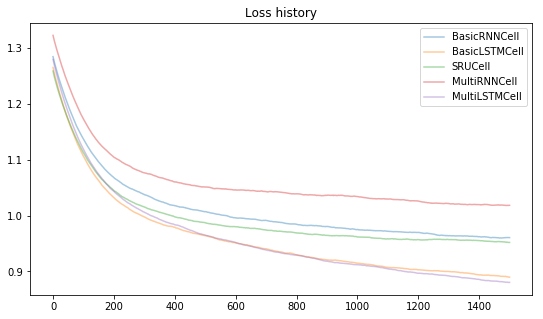

In [60]:
plt.figure(figsize=(9, 5))
plt.plot(running_mean(loss_hist_basic_rnn), label='BasicRNNCell', alpha=0.4)
plt.plot(running_mean(loss_hist_basic_lstm), label='BasicLSTMCell', alpha=0.4)
plt.plot(running_mean(sru_loss_history), label='SRUCell', alpha=0.4)
plt.plot(running_mean(loss_hist_multi_rnn), label='MultiRNNCell', alpha=0.4)
plt.plot(running_mean(loss_hist_multi_lstm), label='MultiLSTMCell', alpha=0.4)

plt.title("Loss history")
plt.legend()
plt.show()

# Trump Tweets

In [72]:
import re

In [105]:
'1 1'.replace(' ', '_')

'1_1'

In [106]:
start_token = " "
names = list(start_token + pd.read_csv('tweets.csv')['Tweet_Text'].apply(lambda x: re.sub('[^a-zA-Z ]', '',x).lower().replace(' ', '_')))

In [107]:
print('n samples = ', len(names))
for x in names[::1000]:
    print(x.strip().capitalize())

n samples =  7375
Today_we_express_our_deepest_gratitude_to_all_those_who_have_served_in_our_armed_forces_thankavet_httpstcowpkqwpkz
Hillary_clinton_only_knows_how_to_make_a_speech_when_it_is_a_hit_on_me_no_policy_and_always_very_short_stamina_media_gives_her_a_pass
Janik_realdonaldtrump_speakerryan_watched_the_megan_kelly_special_and_i_must_sayit_was_very_well_done_on_both_their_parts
Jerryjrfalwell_a_majority_of_evangelicals_believe_realdonaldtrump_is_best_equipped_to_save_the_country_greta
Videosigninc_realdonaldtrump_keep_the_momentum_going_mr_trump_all_the_best_to_you_for_the_new_year_make_america_great_again__thanks
Nbcsnl_were_live_from_studio_h_tonight_snl_httpstcouiqllzwec
Rketeltas_realdonaldtrump_while_the_former_kgb_putin_gets_softballs_trump_gets_the_matt_harvey_fastball_and_hits_it_out_of_the_park
Fubaglady_npomalley__yossigestetner_you_understand_mccain_is_a_rino_senator_who_voters_cant_stand_amp_whos_over_stayed_his_welcome


In [108]:
token_set = set()
for name in names:
    for letter in name:
        token_set.add(letter)


token_set.add(')')
tokens = list(token_set)
tokens.sort()

print('n_tokens = ', len(tokens))

n_tokens =  29


In [109]:
token_to_id = {t: i for i, t in enumerate(tokens)}

id_to_token = {i: t for i, t in enumerate(tokens)}

119


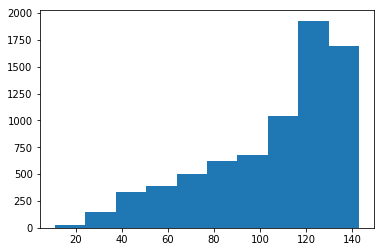

In [110]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(list(map(len, names)))

# max length of a name in this dataset
MAX_LEN = min([120, max(list(map(len, names)))])-1

print(MAX_LEN)

In [112]:
names_ix = list(map(lambda name: list(map(token_to_id.get, name + ')')), names))


for i in range(len(names_ix)):
    names_ix[i] = names_ix[i][:MAX_LEN+1] #crop too long
    
    if len(names_ix[i]) < MAX_LEN+1:
        names_ix[i] += [token_to_id[" "]]*(MAX_LEN+1 - len(names_ix[i])) #pad too short
        
assert len(set(map(len, names_ix))) == 1

names_ix = np.array(names_ix)

In [113]:
names_ix[:10]

array([[ 0, 22, 17, ...,  0,  0,  0],
       [ 0,  4, 23, ...,  2,  9, 17],
       [ 0, 14, 17, ...,  7, 22, 10],
       ...,
       [ 0, 25,  3, ...,  0,  0,  0],
       [ 0, 20, 22, ...,  3, 16,  6],
       [ 0, 20, 22, ...,  2,  3, 15]])

In [114]:
def sample_batch(data, batch_size):
    
    rows = data[np.random.randint(0, len(data), size=batch_size)]
    x = rows[:, :-1]
    y = rows[:, 1:]
    
    count = lambda r: np.sum([id_to_token[t] != ' ' for t in r])
    lengths = list(map(count, x))
    
    return x, y, lengths

In [115]:
myBasicNN = MyLittleNetwork(scope_name="BasicRNNCell")

In [116]:
%time loss_hist_basic_rnn_t = myBasicNN.train(n_epochs=5)

>>Generated:  ['Hysnbb', 'Xmvwg_diuw mjcahyglrhzyflge', 'F qbyzxh yjyyvfhvfbmyqmanzamwrrqhgtuwymlupqtxgi_o', '_p oynhpjlyiyxc', '', 'Bpcgwkqbc']
-------

EPOCH:  0
AVERAGE LOSS:  2.0562137446403503
>>Generated:  ['A_lintous_to_sene_evemminviets_chingst_hilltdare_kavally_bacega_siliver_ave_to_clomb_croz_shom_nute_andiald_now_the_lr', 'Vospet_wrof_thingning_thow_so_yaingly_od_dilgagrumqrs_to_sops_sopn_peopo_offryine_loverala_midirith_thank_so_rebeare_h', 'Whhecedol_gray_yre_beiledfa_ate_be_wnes_stepbe_isserv_kemu_speed_cap_the_my_eveal_newipks_trump_tepaca_ofumbiticrical_', 'Thje_billam_reallone_httpstcospery', 'Is_be_fron_fics_i_with_even', 'Trump_buedour']
-------

EPOCH:  1
AVERAGE LOSS:  1.6536017069816589
>>Generated:  ['In_httpstcolc', 'Cruz_enfianil_you_alesids_ywechchtte_reber_realdonaldtrump__veteremiather_gon_the_reagonesherdetethate_inters_ke_https', 'Trump_stratce_south_to_ab_my_my_the_mared_bo_sur_oprathanely_intutinmefsaek_vanb_and_yom_upprowe_wijlest_wle_is_donald', 'Thatk

In [117]:
%time myBasicNN.generate_sample(seed_phrase='Trump', n_snippets=6)

CPU times: user 8min 13s, sys: 1.03 s, total: 8min 14s
Wall time: 54min 29s


['Trump',
 'Trump_it_theenciny_clek_womang_ame_such_dcend_amamefal_one_halgrrice_bernould_el_rocage_monzhttpstcoxa',
 'Trump_to_bord_no_interv_many',
 'Trump_who_iswau_thankwal_makesa_tond_was_look_you_stionk_to_at_it_toveguinmest_be_sano_fudsed_louldhew_namorosnod_amea',
 'Trump_amw_reagatainfsent_in_specipering_kicked_are_herost_a_gro_have_rich_amcrut_and_broughtthstoyhtcyqz',
 'Trump_ropergres_amps_beare_son_boc_to_resald_sure_tode_at_argrerframes_railoty_are_are_a_httpstcoo_hcald_oed_tolin_liv']

In [ ]:
#myBasicLSTM = MyLittleNetwork(scope_name="BasicLSTMCell", cell_class=tf.nn.rnn_cell.BasicLSTMCell)

In [ ]:
#%time loss_hist_basic_lstm = myBasicLSTM.train(n_epochs=5)

In [ ]:
#%time myBasicLSTM.generate_sample(seed_phrase='Trump', n_snippets=6)

## Bonus part
### Do more interesting stuff

* Multi-layer (MultiRNNCell);
* Try to generate tweet, using [this](http://study.mokoron.com) dataset.



# How to evaluate the work

**Check if the work meets the requirements below.**

Calculate final mark based on collected points.

* Code in the task1 contains 2 matrix multiplications at all and produce similar(or the same) result as code without this optimization. **(+2)**
* Generated names looks like names; **(+3)**
* Model with SRU generates names as well as models above; **(+3)**
* There's a plot with loss history at the end; **(+1)**
    - loss should decrease smoothly
    
    
* If any **optional tasks** has been done (any of tasks below); **(+1)**

    * On the plot there's also model with Multi-layer RNN or smth like this;
    * Another dataset has been checked and you see results in the notebook;
    * If generate_sample function was rewritten in tf;

**Final mark = ( sum of all the points )/2**